# RNNs and LSTMs from Scratch

**The question we're answering:** How do neural networks "remember" across time?

Feedforward networks process each input independently—they have no memory. But language, music, and time-series data are *sequential*: the meaning of "bank" depends on whether we just saw "river" or "money."

This notebook builds intuition for how RNNs and LSTMs solve this problem. We'll discover:
1. Why sharing weights across time lets us process sequences
2. Why training RNNs is surprisingly hard (the vanishing gradient problem)
3. How LSTMs solve this with a clever "cell state" that acts like a conveyor belt

By the end, the LSTM architecture—which looks intimidating at first—will feel like the *obvious* solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Style settings
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3


## The Core RNN Idea

The simplest way to add memory: **use the previous output as additional input**.

At each timestep $t$, the RNN combines:
- The current input $x_t$ 
- The previous hidden state $h_{t-1}$ (this is the "memory")

$$h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b)$$

**Key insight:** The same weights $W_{xh}$ and $W_{hh}$ are used at every timestep. This is what makes it "recurrent"—we're applying the same function over and over, just with different inputs.

Let's build this from scratch. We'll process the sentence "The cat sat" character by character.

In [2]:
# | simple-rnn-cell inline expanded code-aside
class SimpleRNNCell:
    """A single RNN cell implemented from scratch."""
    
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size
        
        # Initialize weights (using Xavier/Glorot initialization)
        scale = np.sqrt(2.0 / (input_size + hidden_size))
        self.W_xh = np.random.randn(input_size, hidden_size) * scale
        self.W_hh = np.random.randn(hidden_size, hidden_size) * scale
        self.b = np.zeros(hidden_size)
        
    def forward(self, x, h_prev):
        """Single forward step: h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b)"""
        h_new = np.tanh(x @ self.W_xh + h_prev @ self.W_hh + self.b)
        return h_new
    
    def init_hidden(self, batch_size):
        """Initialize hidden state to zeros."""
        return np.zeros((batch_size, self.hidden_size))

# Let's process "The cat sat" one character at a time
# First, create simple one-hot encodings for our characters
text = "The cat sat"
chars = sorted(set(text))
char_to_idx = {c: i for i, c in enumerate(chars)}

print(f"Our vocabulary: {chars}")
print(f"Vocabulary size: {len(chars)}")

# One-hot encode each character
def one_hot(char, vocab_size):
    vec = np.zeros((1, vocab_size))
    vec[0, char_to_idx[char]] = 1.0
    return vec

# Create RNN: input_size = vocab_size, hidden_size = 8 (small for visualization)
rnn_cell = SimpleRNNCell(input_size=len(chars), hidden_size=8)
h = rnn_cell.init_hidden(1)

print(f"\nProcessing '{text}' character by character:")
print("-" * 50)

for i, char in enumerate(text):
    x = one_hot(char, len(chars))
    h = rnn_cell.forward(x, h)
    # Show how hidden state evolves
    print(f"'{char}' -> h mean: {h.mean():.3f}, h std: {h.std():.3f}")

Our vocabulary: [' ', 'T', 'a', 'c', 'e', 'h', 's', 't']
Vocabulary size: 8

Processing 'The cat sat' character by character:
--------------------------------------------------
'T' -> h mean: -0.193, h std: 0.252
'h' -> h mean: -0.186, h std: 0.291
'e' -> h mean: -0.046, h std: 0.441
' ' -> h mean: 0.191, h std: 0.480
'c' -> h mean: 0.182, h std: 0.427
'a' -> h mean: -0.034, h std: 0.462
't' -> h mean: -0.124, h std: 0.315
' ' -> h mean: 0.118, h std: 0.344
's' -> h mean: 0.150, h std: 0.406
'a' -> h mean: 0.115, h std: 0.409
't' -> h mean: -0.114, h std: 0.222


Notice how each character changes the hidden state. After seeing "The c", the hidden state contains a *compressed summary* of everything seen so far.

## Processing Full Sequences

In practice, we wrap our RNN cell to process entire sequences at once, storing all hidden states for later use.

In [3]:
class SimpleRNN:
    """Full RNN that processes sequences and stores all hidden states."""
    
    def __init__(self, input_size, hidden_size):
        self.cell = SimpleRNNCell(input_size, hidden_size)
        self.hidden_size = hidden_size
        
    def forward(self, sequence):
        """Process an entire sequence.
        
        Args:
            sequence: (seq_len, batch_size, input_size)
        
        Returns:
            outputs: All hidden states (seq_len, batch_size, hidden_size)
            h_final: Final hidden state (batch_size, hidden_size)
        """
        seq_len, batch_size, _ = sequence.shape
        h = self.cell.init_hidden(batch_size)
        
        outputs = []
        for t in range(seq_len):
            h = self.cell.forward(sequence[t], h)
            outputs.append(h)
            
        return np.stack(outputs), h

# Prepare our text as a sequence of one-hot vectors
sequence = np.stack([one_hot(c, len(chars))[0] for c in text])  # (seq_len, vocab_size)
sequence = sequence[:, np.newaxis, :]  # Add batch dim: (seq_len, 1, vocab_size)

print(f"Sequence shape: {sequence.shape} = (seq_len={len(text)}, batch=1, vocab={len(chars)})")

# Process with our RNN
rnn = SimpleRNN(input_size=len(chars), hidden_size=8)
all_hidden, final_hidden = rnn.forward(sequence)

print(f"All hidden states shape: {all_hidden.shape}")
print(f"Final hidden state shape: {final_hidden.shape}")
print(f"\nThe final hidden state is our 'summary' of '{text}'")

Sequence shape: (11, 1, 8) = (seq_len=11, batch=1, vocab=8)
All hidden states shape: (11, 1, 8)
Final hidden state shape: (1, 8)

The final hidden state is our 'summary' of 'The cat sat'


## Visualizing Hidden States Over Time

**What to look for:** In the heatmap below, each column is a timestep (a character from our text). Each row is a hidden unit. Watch how the pattern of activations changes as we read through "The cat sat".

**Hypothesis:** If the RNN is working, we should see:
1. Similar patterns when we see the same character (e.g., 'a' appears twice)
2. Distinct patterns for different characters
3. Smooth transitions—nearby timesteps should look related

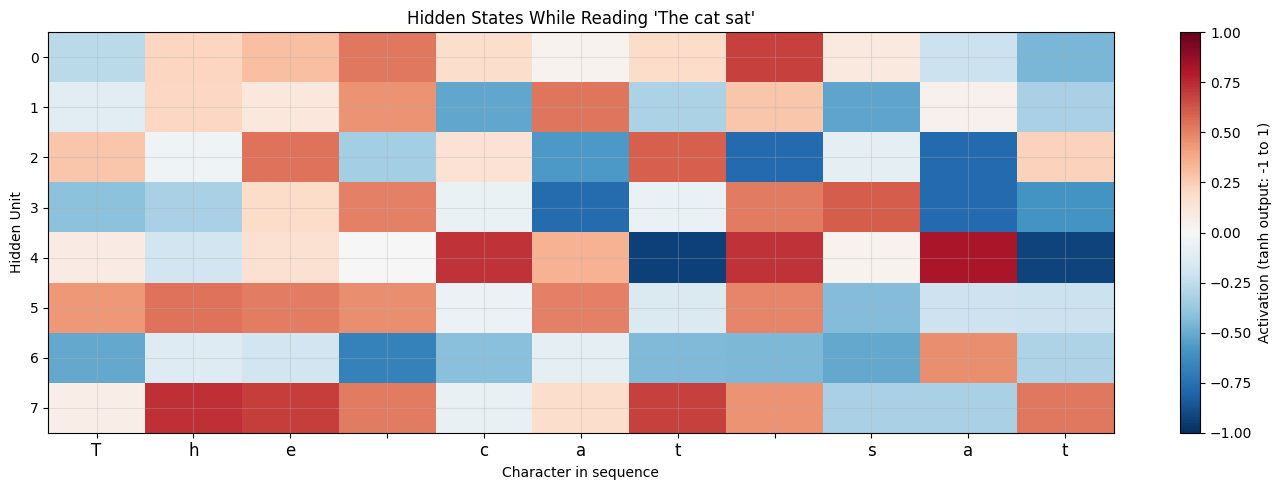

In [4]:
# | unroll-viz inline visualization
def visualize_hidden_states(outputs, chars_sequence, title="Hidden State Evolution"):
    """Visualize how hidden states evolve over time."""
    states = outputs[:, 0, :]  # Take first batch: (seq_len, hidden_size)
    
    fig, ax = plt.subplots(figsize=(14, 5))
    im = ax.imshow(states.T, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    
    # Label x-axis with actual characters
    ax.set_xticks(range(len(chars_sequence)))
    ax.set_xticklabels(list(chars_sequence), fontsize=12)
    
    plt.colorbar(im, label='Activation (tanh output: -1 to 1)')
    ax.set_xlabel('Character in sequence')
    ax.set_ylabel('Hidden Unit')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

visualize_hidden_states(all_hidden, text, f"Hidden States While Reading '{text}'")

## Training RNNs: Backpropagation Through Time (BPTT)

Now we understand the forward pass. But how do we *train* this thing?

**The key insight:** When we unroll an RNN across time, it looks like a very deep feedforward network where each "layer" is a timestep.

To compute gradients, we backpropagate through this unrolled network. The gradient for the weights at timestep $t$ depends on *all future timesteps*:

$$\frac{\partial L}{\partial W} = \sum_{t=1}^{T} \frac{\partial L_t}{\partial h_t} \cdot \underbrace{\prod_{k=1}^{t} \frac{\partial h_k}{\partial h_{k-1}}}_{\text{This product is the problem!}}$$

That product of Jacobians is where things go wrong. Let's implement BPTT to see what happens.

In [5]:
# | bptt-impl inline expanded code-aside
class RNNWithBPTT:
    """RNN with full BPTT implementation to track gradient flow."""
    
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size
        self.input_size = input_size
        
        # Initialize weights
        scale = np.sqrt(2.0 / (input_size + hidden_size))
        self.W_xh = np.random.randn(input_size, hidden_size) * scale
        self.W_hh = np.random.randn(hidden_size, hidden_size) * scale
        self.b = np.zeros(hidden_size)
        
    def forward(self, sequence):
        """Forward pass, storing values needed for backprop."""
        seq_len, batch_size, _ = sequence.shape
        
        self.inputs = sequence
        self.hiddens = [np.zeros((batch_size, self.hidden_size))]
        self.pre_activations = []
        
        for t in range(seq_len):
            pre_act = sequence[t] @ self.W_xh + self.hiddens[-1] @ self.W_hh + self.b
            h = np.tanh(pre_act)
            self.pre_activations.append(pre_act)
            self.hiddens.append(h)
            
        return np.stack(self.hiddens[1:]), self.hiddens[-1]
    
    def backward(self, d_outputs):
        """Full BPTT backward pass. Returns gradient magnitudes at each timestep."""
        seq_len = len(self.pre_activations)
        batch_size = d_outputs.shape[1]
        
        # Gradient flowing back through hidden states
        dh_next = np.zeros((batch_size, self.hidden_size))
        grad_magnitudes = []
        
        # Backprop through time (reverse order!)
        for t in reversed(range(seq_len)):
            dh = d_outputs[t] + dh_next
            
            # Gradient through tanh: d/dx tanh(x) = 1 - tanh(x)^2
            d_pre_act = dh * (1 - np.tanh(self.pre_activations[t])**2)
            
            # Gradient to previous hidden state (this is what we multiply repeatedly)
            dh_next = d_pre_act @ self.W_hh.T
            
            grad_magnitudes.append(np.linalg.norm(dh_next))
            
        return list(reversed(grad_magnitudes))

# Test on a 10-step sequence
rnn_bptt = RNNWithBPTT(input_size=len(chars), hidden_size=8)
outputs, _ = rnn_bptt.forward(sequence)

# Imagine our loss is the sum of all outputs
d_outputs = np.ones_like(outputs) * 0.1
grad_mags = rnn_bptt.backward(d_outputs)

print("Gradient magnitude at each timestep (from end back to start):")
print("-" * 55)
for t, (char, mag) in enumerate(zip(text, grad_mags)):
    bar = "#" * int(mag * 50)
    print(f"t={t:2d} '{char}': {mag:.4f} {bar}")

print("\n** KEY TAKEAWAY **")
print("Notice: gradients are NOT decaying much here because our sequence is short (11 chars).")
print("The vanishing gradient problem appears with LONGER sequences. Let's see that next.")

Gradient magnitude at each timestep (from end back to start):
-------------------------------------------------------
t= 0 'T': 0.5050 #########################
t= 1 'h': 0.4574 ######################
t= 2 'e': 0.4914 ########################
t= 3 ' ': 0.5534 ###########################
t= 4 'c': 0.6156 ##############################
t= 5 'a': 0.5202 ##########################
t= 6 't': 0.4075 ####################
t= 7 ' ': 0.2979 ##############
t= 8 's': 0.3126 ###############
t= 9 'a': 0.2034 ##########
t=10 't': 0.1965 #########

** KEY TAKEAWAY **
Notice: gradients are NOT decaying much here because our sequence is short (11 chars).
The vanishing gradient problem appears with LONGER sequences. Let's see that next.


## The Vanishing Gradient Problem

**Why do gradients vanish?**

During backprop, we multiply gradients through each timestep. If these multiplications are mostly < 1, the gradient shrinks exponentially.

Think about it: if you multiply 0.9 by itself 100 times, you get $0.9^{100} \approx 0.00003$.

**What to look for in the plot below:**
- Each line is a different sequence length
- The y-axis (log scale) shows gradient magnitude relative to the final timestep
- Watch how the gradient at the *start* of the sequence gets smaller as sequences get longer
- For length 100: the first timestep gets almost no gradient signal!

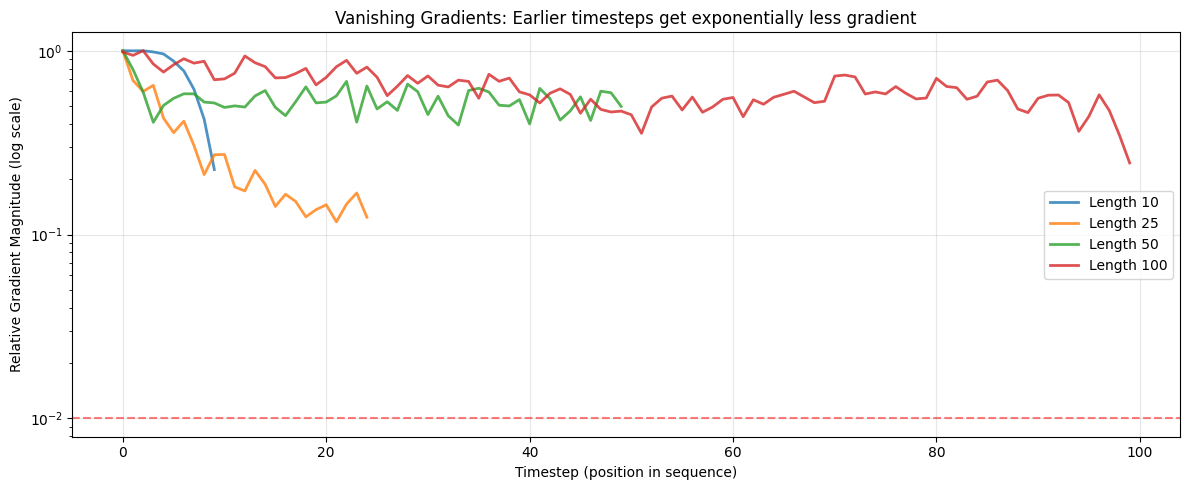

IMPLICATION: For length-100 sequences, the RNN can barely learn from the first 50 tokens!
This is why vanilla RNNs fail at long-range dependencies.


In [6]:
# | vanishing-demo inline visualization
def demonstrate_vanishing_gradients(seq_lengths=[10, 25, 50, 100]):
    """Show how gradients vanish with increasing sequence length."""
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    for seq_len in seq_lengths:
        # Create random sequence data
        fake_sequence = np.random.randn(seq_len, 1, 10) * 0.1
        
        rnn = RNNWithBPTT(input_size=10, hidden_size=20)
        outputs, _ = rnn.forward(fake_sequence)
        d_outputs = np.ones_like(outputs) * 0.1
        grad_mags = rnn.backward(d_outputs)
        
        # Normalize so we can compare different lengths
        grad_mags = np.array(grad_mags) / max(grad_mags)
        ax.plot(range(seq_len), grad_mags, label=f'Length {seq_len}', alpha=0.8, linewidth=2)
    
    ax.set_xlabel('Timestep (position in sequence)')
    ax.set_ylabel('Relative Gradient Magnitude (log scale)')
    ax.set_title('Vanishing Gradients: Earlier timesteps get exponentially less gradient')
    ax.legend()
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.01, color='red', linestyle='--', alpha=0.5, label='1% threshold')
    plt.tight_layout()
    plt.show()
    
    print("IMPLICATION: For length-100 sequences, the RNN can barely learn from the first 50 tokens!")
    print("This is why vanilla RNNs fail at long-range dependencies.")

demonstrate_vanishing_gradients()

## The Math Behind Vanishing Gradients

Let's make this concrete with a simple model: what happens when you multiply a number by itself many times?

**Hypothesis:** If our "gradient retention factor" is less than 1 (say, 0.9), after 100 multiplications we'll have essentially nothing left. If it's greater than 1 (say, 1.1), we'll explode to infinity.

**What to look for:**
- Left plot: linear scale shows the gradient plummeting to zero
- Right plot: log scale reveals the exponential nature of decay
- Notice how even 0.9 (which seems close to 1!) leads to almost complete signal loss

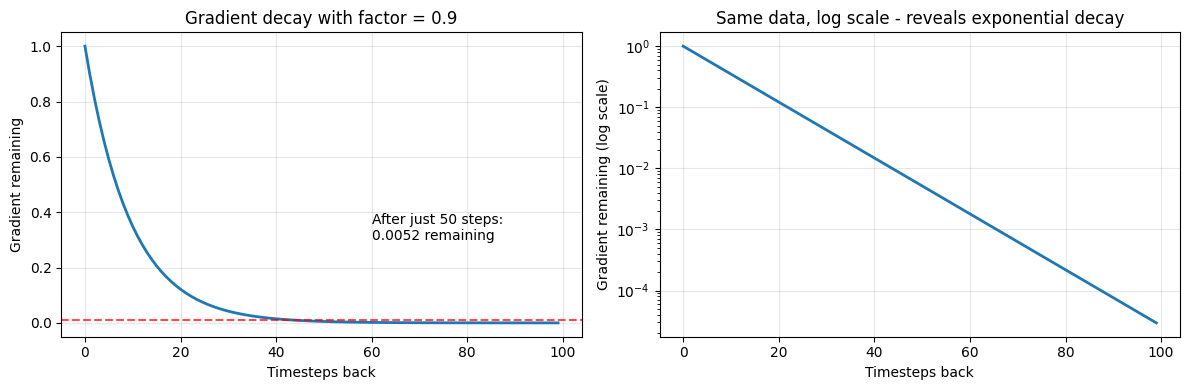

Starting gradient: 1.0
After 50 timesteps:  0.005154 (0.5154%)
After 100 timesteps: 2.66e-05 (0.002656%)

This is why RNNs 'forget' long-range dependencies!
The gradient signal from early tokens is essentially ZERO by the time it reaches the weights.


In [7]:
# | exponential-decay inline visualization
# Exponential decay demonstration
decay_factor = 0.9
timesteps = 100

# What fraction of gradient remains after t steps?
gradient_remaining = [decay_factor ** t for t in range(timesteps)]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale
axes[0].plot(gradient_remaining, linewidth=2)
axes[0].set_xlabel('Timesteps back')
axes[0].set_ylabel('Gradient remaining')
axes[0].set_title(f'Gradient decay with factor = {decay_factor}')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.01, color='red', linestyle='--', alpha=0.7)
axes[0].text(60, 0.3, f'After just 50 steps:\n{decay_factor**50:.4f} remaining', fontsize=10)

# Log scale (reveals exponential nature)
axes[1].semilogy(gradient_remaining, linewidth=2)
axes[1].set_xlabel('Timesteps back')
axes[1].set_ylabel('Gradient remaining (log scale)')
axes[1].set_title('Same data, log scale - reveals exponential decay')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Starting gradient: 1.0")
print(f"After 50 timesteps:  {decay_factor**50:.6f} ({decay_factor**50 * 100:.4f}%)")
print(f"After 100 timesteps: {decay_factor**100:.2e} ({decay_factor**100 * 100:.6f}%)")
print()
print("This is why RNNs 'forget' long-range dependencies!")
print("The gradient signal from early tokens is essentially ZERO by the time it reaches the weights.")

## Gradient Clipping: A Partial Fix

Before we get to LSTMs, let's address the *opposite* problem: **exploding gradients**.

If the gradient retention factor is > 1, gradients grow exponentially. This causes:
- NaN losses during training
- Wild parameter updates that destabilize learning

**The fix:** If gradients get too big, scale them down to a maximum norm. This is called "gradient clipping."

Note: Clipping helps with exploding gradients but does NOT help with vanishing gradients. We need a different architecture for that.

In [8]:
def clip_gradients(gradients, max_norm=1.0):
    """Clip gradients to prevent explosion.
    
    If total_norm > max_norm, scale all gradients down proportionally.
    """
    total_norm = np.sqrt(sum(np.sum(g**2) for g in gradients))
    
    if total_norm > max_norm:
        scale = max_norm / total_norm
        clipped = [g * scale for g in gradients]
        return clipped, True, total_norm
    return gradients, False, total_norm

# Simulate exploding gradients
large_gradients = [np.random.randn(10, 20) * 10 for _ in range(3)]

original_norm = np.sqrt(sum(np.sum(g**2) for g in large_gradients))
clipped, was_clipped, _ = clip_gradients(large_gradients, max_norm=5.0)
clipped_norm = np.sqrt(sum(np.sum(g**2) for g in clipped))

print(f"Original gradient norm: {original_norm:.2f}")
print(f"Max allowed norm: 5.0")
print(f"Was clipped: {was_clipped}")
print(f"Clipped gradient norm: {clipped_norm:.2f}")
print()
print("In PyTorch, this is: torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)")

Original gradient norm: 244.58
Max allowed norm: 5.0
Was clipped: True
Clipped gradient norm: 5.00

In PyTorch, this is: torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)


## The LSTM: Solving Vanishing Gradients

We've seen the problem: gradients vanish because we *multiply* through each timestep.

**The LSTM insight:** What if we could *add* instead of multiply?

The LSTM introduces a **cell state** $C_t$ that flows through time with minimal modification. Think of it like a conveyor belt: information can hop on and off, but the belt itself keeps moving.

Three "gates" control the flow:
1. **Forget gate** ($f_t$): How much of the old cell state to keep (0 = forget everything, 1 = keep everything)
2. **Input gate** ($i_t$): How much of the new candidate to add
3. **Output gate** ($o_t$): How much of the cell state to expose as output

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \quad \text{(forget gate: what to erase)}$$
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \quad \text{(input gate: what to write)}$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \quad \text{(candidate: new information)}$$
$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \quad \text{(update cell state)}$$
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \quad \text{(output gate: what to reveal)}$$
$$h_t = o_t \odot \tanh(C_t) \quad \text{(hidden state)}$$

**Why this helps:** If the forget gate is close to 1, gradients flow through $C_t$ almost unchanged! No vanishing.

In [9]:
# | lstm-impl inline expanded code-aside
def sigmoid(x):
    """Numerically stable sigmoid."""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

class LSTMCell:
    """A single LSTM cell implemented from scratch."""
    
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size
        combined_size = input_size + hidden_size
        scale = np.sqrt(2.0 / combined_size)
        
        # Forget gate weights
        self.W_f = np.random.randn(combined_size, hidden_size) * scale
        self.b_f = np.ones(hidden_size)  # Initialize forget bias to 1! (keep everything at start)
        
        # Input gate weights
        self.W_i = np.random.randn(combined_size, hidden_size) * scale
        self.b_i = np.zeros(hidden_size)
        
        # Candidate values weights
        self.W_c = np.random.randn(combined_size, hidden_size) * scale
        self.b_c = np.zeros(hidden_size)
        
        # Output gate weights
        self.W_o = np.random.randn(combined_size, hidden_size) * scale
        self.b_o = np.zeros(hidden_size)
        
    def forward(self, x, h_prev, c_prev):
        """Single LSTM step. Returns new hidden state, cell state, and gate values."""
        # Concatenate input and previous hidden state
        combined = np.concatenate([x, h_prev], axis=1)
        
        # Compute all gates
        f = sigmoid(combined @ self.W_f + self.b_f)  # Forget: what to erase
        i = sigmoid(combined @ self.W_i + self.b_i)  # Input: what to write
        c_tilde = np.tanh(combined @ self.W_c + self.b_c)  # Candidate: new info
        o = sigmoid(combined @ self.W_o + self.b_o)  # Output: what to reveal
        
        # Update cell state: erase old + write new
        c_new = f * c_prev + i * c_tilde
        
        # Compute hidden state from cell state
        h_new = o * np.tanh(c_new)
        
        gates = {'forget': f, 'input': i, 'output': o, 'candidate': c_tilde}
        return h_new, c_new, gates
    
    def init_state(self, batch_size):
        """Initialize hidden and cell states to zeros."""
        return np.zeros((batch_size, self.hidden_size)), np.zeros((batch_size, self.hidden_size))

# Test LSTM on our "The cat sat" text
lstm_cell = LSTMCell(input_size=len(chars), hidden_size=8)
h, c = lstm_cell.init_state(1)

print(f"Processing '{text}' with LSTM:")
print("-" * 60)

for char in text:
    x = one_hot(char, len(chars))
    h, c, gates = lstm_cell.forward(x, h, c)
    # Show forget gate (most important for understanding LSTM behavior)
    f_mean = gates['forget'].mean()
    print(f"'{char}' -> forget gate mean: {f_mean:.3f} ({'keeping ~' + str(int(f_mean*100)) + '%'})")

Processing 'The cat sat' with LSTM:
------------------------------------------------------------
'T' -> forget gate mean: 0.740 (keeping ~73%)
'h' -> forget gate mean: 0.695 (keeping ~69%)
'e' -> forget gate mean: 0.747 (keeping ~74%)
' ' -> forget gate mean: 0.746 (keeping ~74%)
'c' -> forget gate mean: 0.743 (keeping ~74%)
'a' -> forget gate mean: 0.683 (keeping ~68%)
't' -> forget gate mean: 0.746 (keeping ~74%)
' ' -> forget gate mean: 0.749 (keeping ~74%)
's' -> forget gate mean: 0.766 (keeping ~76%)
'a' -> forget gate mean: 0.671 (keeping ~67%)
't' -> forget gate mean: 0.734 (keeping ~73%)


Notice how the forget gate hovers around 0.6-0.8, meaning the LSTM is keeping most of the cell state at each step. This is how information persists across long sequences!

## Full LSTM for Sequences

In [10]:
class LSTM:
    """Full LSTM that processes sequences."""
    
    def __init__(self, input_size, hidden_size):
        self.cell = LSTMCell(input_size, hidden_size)
        self.hidden_size = hidden_size
        
    def forward(self, sequence, return_all_gates=False):
        """Process a sequence, optionally returning all gate activations."""
        seq_len, batch_size, _ = sequence.shape
        h, c = self.cell.init_state(batch_size)
        
        outputs, cell_states, all_gates = [], [], []
        
        for t in range(seq_len):
            h, c, gates = self.cell.forward(sequence[t], h, c)
            outputs.append(h)
            cell_states.append(c)
            all_gates.append(gates)
            
        result = (np.stack(outputs), (h, c))
        if return_all_gates:
            result = result + (all_gates, np.stack(cell_states))
        return result

# Process our text sequence
lstm = LSTM(input_size=len(chars), hidden_size=8)
outputs, (h_final, c_final), all_gates, cell_states = lstm.forward(sequence, return_all_gates=True)

print(f"Input: '{text}'")
print(f"Sequence shape: {sequence.shape}")
print(f"All outputs shape: {outputs.shape}")
print(f"Cell states shape: {cell_states.shape}")
print(f"\nThe cell state is our 'long-term memory'")
print(f"The hidden state is our 'working memory' (what we expose to the next layer)")

Input: 'The cat sat'
Sequence shape: (11, 1, 8)
All outputs shape: (11, 1, 8)
Cell states shape: (11, 1, 8)

The cell state is our 'long-term memory'
The hidden state is our 'working memory' (what we expose to the next layer)


## Visualizing LSTM Gate Behavior

**What to look for in these plots:**

1. **Forget gate (top-left):** Values close to 1 mean "keep old information." Watch for when it drops—that's when the LSTM decides to "forget" something.

2. **Input gate (top-right):** High values mean "this new input is important, write it to memory." 

3. **Output gate (bottom-left):** Controls what gets exposed. High = "use this cell state for output."

4. **Cell state magnitude (bottom-right):** Shows if information is accumulating. Should grow smoothly, not explode.

The gray dashed line at 0.5 is the "neutral" point—above means "do this," below means "don't."

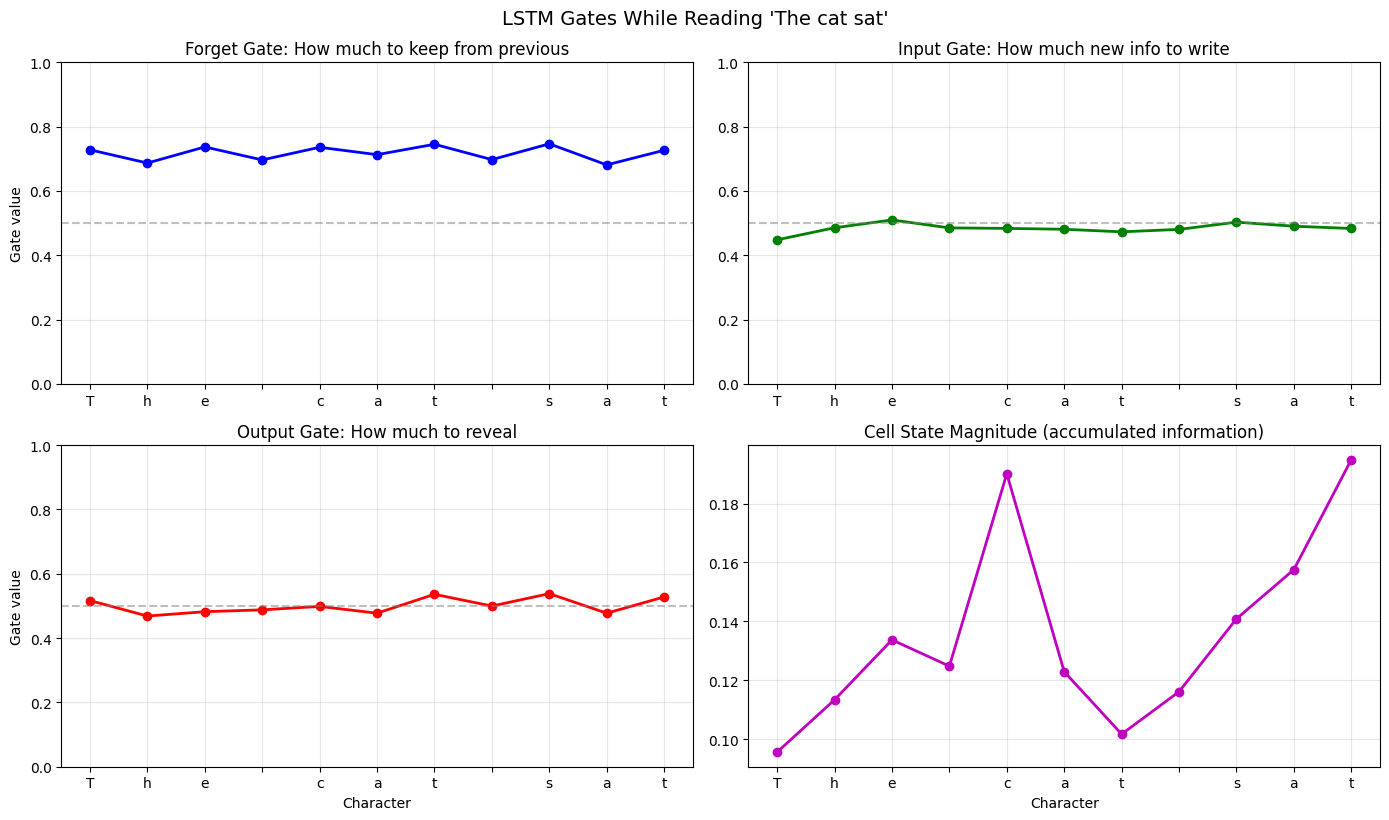

In [11]:
# | visualize-gates inline visualization
def visualize_lstm_gates(all_gates, cell_states, chars_sequence):
    """Visualize how LSTM gates behave while reading text."""
    seq_len = len(all_gates)
    
    # Extract gate values (average across hidden units)
    forget_vals = [g['forget'].mean() for g in all_gates]
    input_vals = [g['input'].mean() for g in all_gates]
    output_vals = [g['output'].mean() for g in all_gates]
    cell_magnitude = [np.abs(c).mean() for c in cell_states]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # Forget gate
    axes[0, 0].plot(forget_vals, 'b-o', linewidth=2, markersize=6)
    axes[0, 0].set_title('Forget Gate: How much to keep from previous')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_ylabel('Gate value')
    axes[0, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0, 0].set_xticks(range(len(chars_sequence)))
    axes[0, 0].set_xticklabels(list(chars_sequence))
    
    # Input gate
    axes[0, 1].plot(input_vals, 'g-o', linewidth=2, markersize=6)
    axes[0, 1].set_title('Input Gate: How much new info to write')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0, 1].set_xticks(range(len(chars_sequence)))
    axes[0, 1].set_xticklabels(list(chars_sequence))
    
    # Output gate
    axes[1, 0].plot(output_vals, 'r-o', linewidth=2, markersize=6)
    axes[1, 0].set_title('Output Gate: How much to reveal')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_xlabel('Character')
    axes[1, 0].set_ylabel('Gate value')
    axes[1, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1, 0].set_xticks(range(len(chars_sequence)))
    axes[1, 0].set_xticklabels(list(chars_sequence))
    
    # Cell state magnitude
    axes[1, 1].plot(cell_magnitude, 'm-o', linewidth=2, markersize=6)
    axes[1, 1].set_title('Cell State Magnitude (accumulated information)')
    axes[1, 1].set_xlabel('Character')
    axes[1, 1].set_xticks(range(len(chars_sequence)))
    axes[1, 1].set_xticklabels(list(chars_sequence))
    
    plt.tight_layout()
    plt.suptitle(f"LSTM Gates While Reading '{chars_sequence}'", y=1.02, fontsize=14)
    plt.show()

visualize_lstm_gates(all_gates, cell_states, text)

## Why Sigmoid for Gates? Why Tanh for Values?

LSTMs make a deliberate choice:
- **Sigmoid (0 to 1)** for gates: We need values that act as "percentages" — how much to keep, write, reveal
- **Tanh (-1 to 1)** for values: We need values that can be positive OR negative, centered around zero

**What to look for below:**
- Sigmoid squashes everything to [0, 1] — perfect for "how much?" questions
- Tanh is zero-centered and bounded — perfect for representing "how positive or negative?"
- ReLU is unbounded and can "die" (output 0 forever) — not suitable for gating

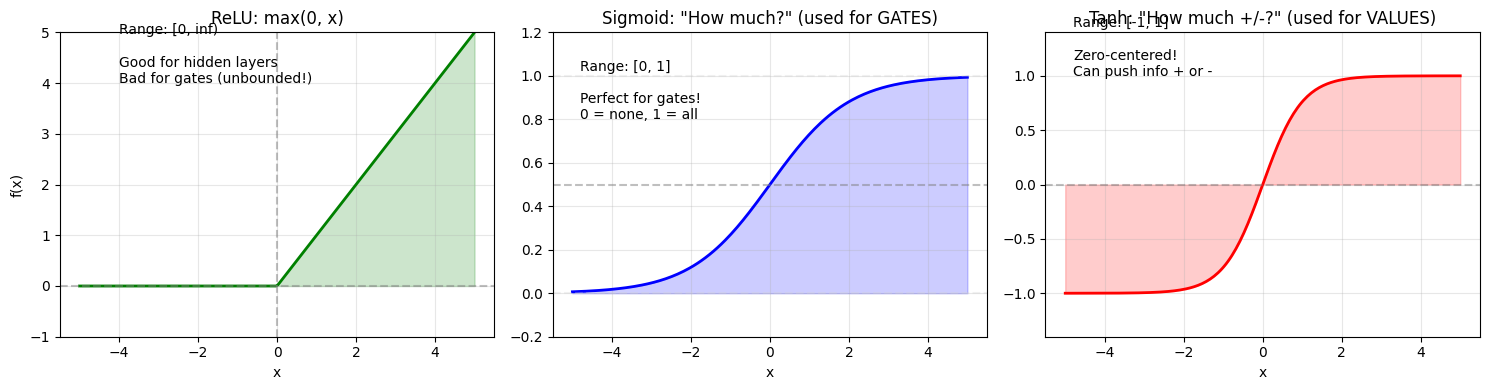

SUMMARY:
- Gates (forget, input, output) use SIGMOID because they answer 'how much?'
- Candidate values use TANH because they can add positive OR negative information
- This is why LSTM gates are sometimes called 'soft switches'


In [12]:
# | activation-comparison inline visualization
def compare_activations():
    """Compare ReLU, Sigmoid, and Tanh to understand why LSTMs use each."""
    x = np.linspace(-5, 5, 200)
    
    relu = np.maximum(0, x)
    sigmoid_vals = 1 / (1 + np.exp(-x))
    tanh_vals = np.tanh(x)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # ReLU
    axes[0].plot(x, relu, 'g-', linewidth=2)
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].fill_between(x, 0, relu, alpha=0.2, color='green')
    axes[0].set_title('ReLU: max(0, x)', fontsize=12)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('f(x)')
    axes[0].set_ylim(-1, 5)
    axes[0].text(-4, 4, 'Range: [0, inf)\n\nGood for hidden layers\nBad for gates (unbounded!)', fontsize=10)
    
    # Sigmoid
    axes[1].plot(x, sigmoid_vals, 'b-', linewidth=2)
    axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].axhline(y=0, color='lightgray', linestyle='--', alpha=0.3)
    axes[1].axhline(y=1, color='lightgray', linestyle='--', alpha=0.3)
    axes[1].fill_between(x, 0, sigmoid_vals, alpha=0.2, color='blue')
    axes[1].set_title('Sigmoid: "How much?" (used for GATES)', fontsize=12)
    axes[1].set_xlabel('x')
    axes[1].set_ylim(-0.2, 1.2)
    axes[1].text(-4.8, 0.8, 'Range: [0, 1]\n\nPerfect for gates!\n0 = none, 1 = all', fontsize=10)
    
    # Tanh
    axes[2].plot(x, tanh_vals, 'r-', linewidth=2)
    axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[2].fill_between(x, 0, tanh_vals, where=(tanh_vals >= 0), alpha=0.2, color='red')
    axes[2].fill_between(x, tanh_vals, 0, where=(tanh_vals < 0), alpha=0.2, color='red')
    axes[2].set_title('Tanh: "How much +/-?" (used for VALUES)', fontsize=12)
    axes[2].set_xlabel('x')
    axes[2].set_ylim(-1.4, 1.4)
    axes[2].text(-4.8, 1, 'Range: [-1, 1]\n\nZero-centered!\nCan push info + or -', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("SUMMARY:")
    print("- Gates (forget, input, output) use SIGMOID because they answer 'how much?'")
    print("- Candidate values use TANH because they can add positive OR negative information")
    print("- This is why LSTM gates are sometimes called 'soft switches'")

compare_activations()

## Initialization Matters: Xavier and He

Proper weight initialization is critical for training deep networks (including unrolled RNNs).

**The problem:** If weights are too large, activations explode. Too small, they vanish. 

**The solution:** Scale weights based on layer size:
- **Xavier/Glorot:** `std = sqrt(1/fan_in)` — good for tanh/sigmoid
- **He:** `std = sqrt(2/fan_in)` — good for ReLU

**What to look for below:** After 10 layers of tanh, random initialization produces either exploded or vanishing activations, while Xavier keeps values in a healthy range.

In [13]:
def compare_initializations():
    """Compare different weight initialization schemes."""
    hidden_size = 256
    num_layers = 10
    
    def forward_random(x):
        """Random initialization (no scaling)."""
        for _ in range(num_layers):
            W = np.random.randn(hidden_size, hidden_size)  # Too big!
            x = np.tanh(x @ W)
        return x
    
    def forward_xavier(x):
        """Xavier/Glorot initialization (proper scaling)."""
        for _ in range(num_layers):
            W = np.random.randn(hidden_size, hidden_size) * np.sqrt(1.0 / hidden_size)
            x = np.tanh(x @ W)
        return x
    
    # Test both
    x = np.random.randn(32, hidden_size)  # Batch of 32
    
    random_out = forward_random(x.copy())
    xavier_out = forward_xavier(x.copy())
    
    print("After 10 tanh layers (hidden_size=256):")
    print("-" * 50)
    print(f"{'Init Method':<15} {'Mean':>10} {'Std':>10} {'Max Abs':>10}")
    print("-" * 50)
    print(f"{'Random':.<15} {random_out.mean():>10.4f} {random_out.std():>10.4f} {np.abs(random_out).max():>10.4f}")
    print(f"{'Xavier':.<15} {xavier_out.mean():>10.4f} {xavier_out.std():>10.4f} {np.abs(xavier_out).max():>10.4f}")
    print()
    print("Random init: activations likely saturated (all -1 or 1) or vanished")
    print("Xavier init: activations stay in a healthy range for learning")

compare_initializations()

After 10 tanh layers (hidden_size=256):
--------------------------------------------------
Init Method           Mean        Std    Max Abs
--------------------------------------------------
Random.........     0.0120     0.9743     1.0000
Xavier.........     0.0030     0.2288     0.7690

Random init: activations likely saturated (all -1 or 1) or vanished
Xavier init: activations stay in a healthy range for learning


## The Proof: LSTM vs RNN Gradient Retention

Now the moment of truth. Let's compare how well gradients flow through RNN vs LSTM.

**What to look for:**
- The y-axis shows gradient magnitude at the *first* input relative to the last
- For RNNs: gradient drops exponentially with sequence length
- For LSTMs: gradient stays relatively stable even for long sequences
- The gap widens dramatically as sequences get longer

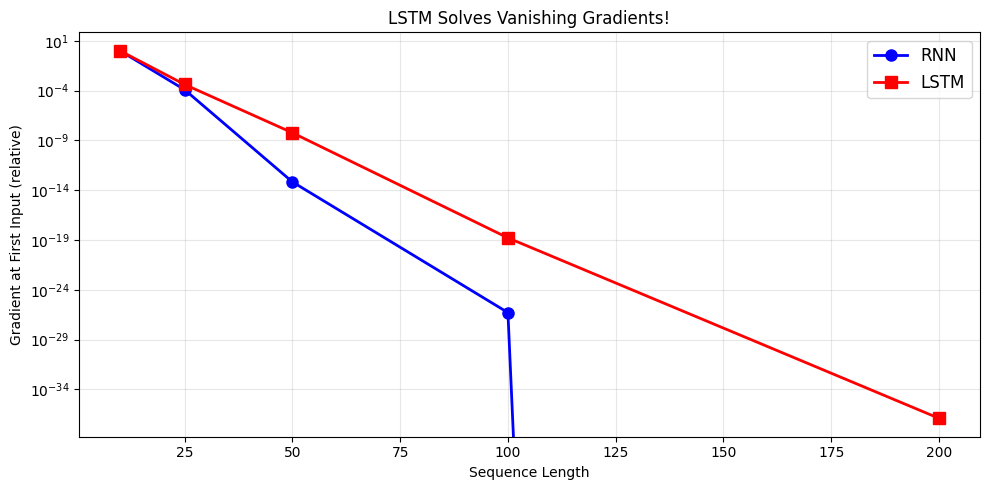

Gradient retention at different sequence lengths:
-------------------------------------------------------
  Length           RNN          LSTM    LSTM/RNN
-------------------------------------------------------
      10      1.000000      1.000000         1.0x
      25      0.000122      0.000408         3.3x
      50      0.000000      0.000000     85742.0x
     100      0.000000      0.000000  31866426.7x
     200      0.000000      0.000000         infx

CONCLUSION: For long sequences, LSTM gradients are ORDERS OF MAGNITUDE larger!
This is why LSTMs can learn long-range dependencies that RNNs cannot.


In [14]:
# | compare-gradient-flow inline visualization
def compare_gradient_retention(seq_lengths=[10, 25, 50, 100, 200]):
    """Compare how RNN and LSTM retain gradients over sequence length."""
    
    rnn_retention = []
    lstm_retention = []
    
    for seq_len in seq_lengths:
        # RNN: gradient at first input when loss is at last output
        rnn = nn.RNN(input_size=10, hidden_size=20, batch_first=False)
        x_rnn = torch.randn(seq_len, 1, 10, requires_grad=True)
        outputs_rnn, _ = rnn(x_rnn)
        loss_rnn = outputs_rnn[-1].sum()  # Loss at final timestep only
        loss_rnn.backward()
        rnn_grad = x_rnn.grad[0].abs().mean().item()  # Gradient at FIRST input
        rnn_retention.append(rnn_grad)
        
        # LSTM: same setup
        lstm = nn.LSTM(input_size=10, hidden_size=20, batch_first=False)
        x_lstm = torch.randn(seq_len, 1, 10, requires_grad=True)
        outputs_lstm, _ = lstm(x_lstm)
        loss_lstm = outputs_lstm[-1].sum()
        loss_lstm.backward()
        lstm_grad = x_lstm.grad[0].abs().mean().item()
        lstm_retention.append(lstm_grad)
    
    # Normalize to first value for comparison
    rnn_retention = np.array(rnn_retention) / rnn_retention[0]
    lstm_retention = np.array(lstm_retention) / lstm_retention[0]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(seq_lengths, rnn_retention, 'b-o', label='RNN', linewidth=2, markersize=8)
    ax.plot(seq_lengths, lstm_retention, 'r-s', label='LSTM', linewidth=2, markersize=8)
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('Gradient at First Input (relative)')
    ax.set_title('LSTM Solves Vanishing Gradients!')
    ax.legend(fontsize=12)
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Gradient retention at different sequence lengths:")
    print("-" * 55)
    print(f"{'Length':>8}  {'RNN':>12}  {'LSTM':>12}  {'LSTM/RNN':>10}")
    print("-" * 55)
    for i, seq_len in enumerate(seq_lengths):
        ratio = lstm_retention[i] / rnn_retention[i] if rnn_retention[i] > 0 else float('inf')
        print(f"{seq_len:>8}  {rnn_retention[i]:>12.6f}  {lstm_retention[i]:>12.6f}  {ratio:>10.1f}x")
    
    print()
    print("CONCLUSION: For long sequences, LSTM gradients are ORDERS OF MAGNITUDE larger!")
    print("This is why LSTMs can learn long-range dependencies that RNNs cannot.")

compare_gradient_retention()

## PyTorch's Built-in LSTM

In practice, use PyTorch's optimized CUDA implementation. It handles:
- Bidirectional processing (read sequence both ways)
- Multiple stacked layers
- Dropout between layers
- Efficient batched computation

In [15]:
# PyTorch LSTM with common configuration
pytorch_lstm = nn.LSTM(
    input_size=10,       # Size of each input token
    hidden_size=20,      # Size of hidden state
    num_layers=2,        # Stack 2 LSTM layers
    dropout=0.1,         # Dropout between layers (not on last layer)
    bidirectional=False, # Process forward only (True = both directions)
    batch_first=True     # Input shape: (batch, seq_len, features)
)

# Count parameters
total_params = sum(p.numel() for p in pytorch_lstm.parameters())
print(f"Total parameters: {total_params:,}")

# Forward pass
x = torch.randn(4, 15, 10)  # batch=4, seq_len=15, features=10
outputs, (h_n, c_n) = pytorch_lstm(x)

print(f"\nInput shape:       {tuple(x.shape)} = (batch, seq_len, input_size)")
print(f"Output shape:      {tuple(outputs.shape)} = (batch, seq_len, hidden_size)")
print(f"Final hidden:      {tuple(h_n.shape)} = (num_layers, batch, hidden_size)")
print(f"Final cell state:  {tuple(c_n.shape)} = (num_layers, batch, hidden_size)")
print()
print("Tip: Use outputs for sequence labeling (POS tagging), h_n for classification")

Total parameters: 5,920

Input shape:       (4, 15, 10) = (batch, seq_len, input_size)
Output shape:      (4, 15, 20) = (batch, seq_len, hidden_size)
Final hidden:      (2, 4, 20) = (num_layers, batch, hidden_size)
Final cell state:  (2, 4, 20) = (num_layers, batch, hidden_size)

Tip: Use outputs for sequence labeling (POS tagging), h_n for classification


## Putting It Together: Character-Level Language Model

Let's train a tiny LSTM to predict the next character. This demonstrates:
1. How to use LSTM for sequence-to-sequence prediction
2. That even tiny models can learn patterns from repetitive text

**Note:** This is a minimal 200-step training loop on tiny data. Real language models train on gigabytes of text for days.

In [16]:
# | char-lm inline expanded code-aside
class CharLSTM(nn.Module):
    """Simple character-level LSTM language model."""
    
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        outputs, hidden = self.lstm(embedded, hidden)
        logits = self.fc(outputs)
        return logits, hidden
    
    def generate(self, start_char, char_to_idx, idx_to_char, length=50, temperature=0.8):
        """Generate text starting from a character."""
        self.eval()
        generated = [start_char]
        x = torch.tensor([[char_to_idx[start_char]]])
        hidden = None
        
        with torch.no_grad():
            for _ in range(length):
                logits, hidden = self(x, hidden)
                probs = F.softmax(logits[0, -1] / temperature, dim=0)
                next_idx = torch.multinomial(probs, 1).item()
                generated.append(idx_to_char[next_idx])
                x = torch.tensor([[next_idx]])
        
        return ''.join(generated)

# Training data: repetitive text so our tiny model can learn something
train_text = "hello world hello neural network hello lstm hello deep learning " * 20

# Build vocabulary
train_chars = sorted(set(train_text))
train_char_to_idx = {c: i for i, c in enumerate(train_chars)}
train_idx_to_char = {i: c for c, i in train_char_to_idx.items()}

print(f"Training text length: {len(train_text)} characters")
print(f"Vocabulary: {''.join(train_chars)}")
print(f"Vocabulary size: {len(train_chars)}")

# Create model
model = CharLSTM(vocab_size=len(train_chars), embed_size=16, hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Convert text to tensor
data = torch.tensor([train_char_to_idx[c] for c in train_text])

# Training loop
print("\nTraining for 200 steps...")
model.train()
seq_length = 30
losses = []

for step in range(200):
    # Random starting position
    start = np.random.randint(0, len(data) - seq_length - 1)
    x = data[start:start + seq_length].unsqueeze(0)
    y = data[start + 1:start + seq_length + 1].unsqueeze(0)
    
    optimizer.zero_grad()
    logits, _ = model(x)
    loss = F.cross_entropy(logits.view(-1, len(train_chars)), y.view(-1))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (step + 1) % 50 == 0:
        print(f"Step {step+1}: loss = {loss.item():.3f}")

# Generate some text
print("\n" + "="*50)
print("Generated text (starting with 'h'):")
print("="*50)
print(model.generate('h', train_char_to_idx, train_idx_to_char, length=100))

Training text length: 1280 characters
Vocabulary:  adeghiklmnoprstuw
Vocabulary size: 18

Training for 200 steps...
Step 50: loss = 0.166
Step 100: loss = 0.086
Step 150: loss = 0.161
Step 200: loss = 0.081

Generated text (starting with 'h'):
hello neural network hello lstm hello deep learning hello world hello neural network hello lstm hello


## Beyond LSTMs: What Came Next

LSTMs dominated NLP from 2014-2017, enabling breakthroughs in:
- Machine translation (seq2seq with attention)
- Speech recognition
- Sentiment analysis
- Text generation

But LSTMs have limitations:
- **Sequential processing:** Can't parallelize across timesteps (slow to train)
- **Fixed memory:** Cell state is a fixed-size vector (hard to store many facts)
- **No direct access:** To use information from timestep 5 at timestep 100, it must pass through all intermediate steps

**The Transformer (2017)** solved these by replacing recurrence with **attention**—letting each position directly attend to all other positions. This enables massive parallelization and led to GPT, BERT, and modern LLMs.

But the intuitions from this notebook carry forward:
- Residual connections (like the cell state conveyor belt) are everywhere
- Gating mechanisms appear in transformers too (GLU, Mamba)
- The vanishing gradient problem drove the development of normalization techniques

In [17]:
# Historical context: Important LSTM-based models

print("Key LSTM Milestones:")
print("-" * 60)
print("1997: LSTM invented (Hochreiter & Schmidhuber)")
print("2014: Seq2seq for translation (Sutskever et al.)")
print("2015: Attention mechanism (Bahdanau et al.)")
print("2016: AWD-LSTM achieves SOTA language modeling")
print("2017: Transformer - 'Attention Is All You Need'")
print("2018: BERT, GPT - transformers dominate NLP")
print()
print("LSTMs are still used in edge cases (low latency, streaming),")
print("but transformers have taken over for most NLP tasks.")

Key LSTM Milestones:
------------------------------------------------------------
1997: LSTM invented (Hochreiter & Schmidhuber)
2014: Seq2seq for translation (Sutskever et al.)
2015: Attention mechanism (Bahdanau et al.)
2016: AWD-LSTM achieves SOTA language modeling
2017: Transformer - 'Attention Is All You Need'
2018: BERT, GPT - transformers dominate NLP

LSTMs are still used in edge cases (low latency, streaming),
but transformers have taken over for most NLP tasks.


## Practice Problems

Test your understanding with these exercises.

In [18]:
# EXERCISE 1: Implement a GRU cell
# GRU is a simplified LSTM with only 2 gates (reset and update) instead of 3
# 
# Equations:
#   r_t = sigmoid(W_r @ [h_{t-1}, x_t])     # reset gate
#   z_t = sigmoid(W_z @ [h_{t-1}, x_t])     # update gate
#   h_tilde = tanh(W_h @ [r_t * h_{t-1}, x_t])  # candidate
#   h_t = (1 - z_t) * h_{t-1} + z_t * h_tilde  # new hidden state
#
# Notice: No separate cell state! The update gate decides how much old vs new.

class GRUCell:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size
        combined_size = input_size + hidden_size
        scale = np.sqrt(2.0 / combined_size)
        
        # Fill in: Initialize weights for reset gate, update gate, and candidate
        # self.W_r = ...
        # self.W_z = ...
        # self.W_h = ...
        pass
    
    def forward(self, x, h_prev):
        # Fill in: Implement the GRU equations
        # Return: h_new
        pass

# Test your implementation:
# test_gru = GRUCell(input_size=10, hidden_size=20)
# test_x = np.random.randn(1, 10)
# test_h = np.zeros((1, 20))
# test_h_new = test_gru.forward(test_x, test_h)
# assert test_h_new.shape == (1, 20), f"Expected shape (1, 20), got {test_h_new.shape}"
# print("GRU cell works!")

In [19]:
# EXERCISE 2: What happens if you initialize forget bias to 0 instead of 1?
#
# Hypothesis: _______________________________________________
#
# Run this experiment and explain the results:

def test_forget_bias_initialization():
    """Compare LSTM with forget bias = 0 vs forget bias = 1"""
    
    # LSTM with forget bias = 0 (fill in the initialization)
    # lstm_forget0 = ...
    
    # LSTM with forget bias = 1 (our original)
    # lstm_forget1 = ...
    
    # Process a sequence and compare:
    # - How do the forget gate values differ?
    # - What happens to cell state magnitude over time?
    
    pass

# Your answer: Why does forget bias = 1 work better for long sequences?
# _______________________________________________

In [20]:
# EXERCISE 3: Bidirectional RNN
#
# Sometimes context from the FUTURE helps understand the present:
# "The bank by the river was muddy" - seeing "river" helps interpret "bank"
#
# Implement a bidirectional wrapper that:
# 1. Processes sequence forward: [x1, x2, x3] -> [h1_fwd, h2_fwd, h3_fwd]
# 2. Processes sequence backward: [x3, x2, x1] -> [h1_bwd, h2_bwd, h3_bwd]
# 3. Concatenates: [h1_fwd;h1_bwd, h2_fwd;h2_bwd, h3_fwd;h3_bwd]

class BidirectionalRNN:
    def __init__(self, input_size, hidden_size):
        self.forward_rnn = SimpleRNN(input_size, hidden_size)
        self.backward_rnn = SimpleRNN(input_size, hidden_size)
        
    def forward(self, sequence):
        """
        Args:
            sequence: (seq_len, batch_size, input_size)
        Returns:
            outputs: (seq_len, batch_size, hidden_size * 2)  # Concatenated!
        """
        # Fill in:
        # 1. Run forward RNN on sequence
        # 2. Run backward RNN on reversed sequence
        # 3. Reverse backward outputs so they align with forward
        # 4. Concatenate along hidden dimension
        pass

# Test:
# test_birnn = BidirectionalRNN(input_size=10, hidden_size=8)
# test_seq = np.random.randn(5, 1, 10)
# test_out = test_birnn.forward(test_seq)
# assert test_out.shape == (5, 1, 16), f"Expected (5, 1, 16), got {test_out.shape}"
# print("Bidirectional RNN works!")

## Summary: The Journey from RNN to LSTM

We started with a simple question: **How can neural networks remember across time?**

### The RNN Answer
Use the previous hidden state as additional input. Same weights at every timestep.
```
h_t = tanh(W_xh @ x_t + W_hh @ h_{t-1} + b)
```

### The Problem
Training via BPTT multiplies gradients through each timestep. These products either:
- **Vanish** (factor < 1): Early tokens get no gradient signal
- **Explode** (factor > 1): Gradients blow up to infinity

### The LSTM Solution
Add a **cell state** that flows through time via addition (not multiplication!). Three gates control:
- **Forget:** What to erase from memory
- **Input:** What new information to write
- **Output:** What to reveal to the next layer

When the forget gate is close to 1, gradients flow through the cell state almost unchanged. This is why LSTMs can learn long-range dependencies.

### Key Takeaways

1. **Vanishing gradients are exponential** — even 0.9^100 is basically zero
2. **Addition > Multiplication** for gradient flow (residual connections everywhere!)
3. **Sigmoid for gates, tanh for values** — bounded ranges matter
4. **Initialize forget bias to 1** — helps at the start of training
5. **Gradient clipping prevents explosion** but doesn't help vanishing

### What's Next?
Transformers replaced recurrence with attention, enabling massive parallelization. But the LSTM intuitions persist: residual connections, gating mechanisms, and careful initialization all trace back to solving the vanishing gradient problem.